Работа сделана на основании BaseLine, внесены разьяснения по изменениям.

In [1]:
import datetime # для работы со времнем
import gc # сборщик мусора

import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score

from lightgbm import LGBMRegressor

%matplotlib inline

1. Чтение данных

In [2]:
df = pd.read_csv('train.csv')

X = df.drop('Price', axis=1)
y = df[['Price']]

X_final = pd.read_csv('test.csv')

preds_final = pd.DataFrame()
preds_final['Id'] = X_final['Id'].copy()

X.set_index('Id', inplace=True)
X_final.set_index('Id', inplace=True)

print('Строк в трейне:' ,  X.shape[0])
print('Строк в тесте', X_final.shape[0])

del df
gc.collect() 

Строк в трейне: 10000
Строк в тесте 5000


0

In [3]:
X.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B
15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B
4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B
5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B
10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B


In [4]:
# DistrictId - перевел в int32, что более чем достаточно для длинны DistrictId
X['DistrictId'] = X['DistrictId'].astype(np.int32)
X_final['DistrictId'] = X_final['DistrictId'].astype(np.int32)

1. Минимальный EDA
Делайем EDA не просто так, а для:

Исправления выбросов
Заполнения NaN
Идей для генерации новых фич
1.1 Выбросы

In [5]:
X.dtypes

DistrictId         int32
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
dtype: object

In [6]:
X['Rooms'].value_counts()

# > 6 комнат, = 0 комнат

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [7]:
X['KitchenSquare'].value_counts().sort_values()

# Площадь < 3
# Площадь > 1000

54.0         1
72.0         1
96.0         1
66.0         1
48.0         1
40.0         1
2014.0       1
35.0         1
60.0         1
78.0         1
27.0         1
84.0         1
42.0         1
62.0         1
39.0         1
1970.0       1
36.0         1
75.0         1
26.0         1
21.0         1
29.0         1
23.0         1
73.0         1
123.0        1
31.0         1
63.0         1
53.0         1
30.0         2
58.0         2
32.0         2
51.0         2
43.0         2
25.0         2
112.0        2
41.0         2
37.0         2
22.0         3
2.0          4
18.0         6
19.0        11
17.0        12
20.0        14
16.0        16
3.0         22
15.0        31
4.0         39
14.0        51
13.0        67
11.0       233
12.0       249
7.0        609
0.0        697
9.0        843
6.0       1038
10.0      1075
5.0       1169
8.0       1306
1.0       2460
Name: KitchenSquare, dtype: int64

In [8]:
X[X['Square'] < 20].head(5000)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
1748,88,2.0,5.497061,67.628717,1.0,24,22.0,1977,0.127376,B,B,43,8429,3,NaN,3,9,B
11526,27,1.0,4.633498,1.969969,1.0,18,1.0,1977,0.011654,B,B,4,915,0,NaN,0,0,B
10202,6,1.0,2.596351,4.604943,1.0,3,25.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B
13685,0,1.0,17.498542,13.446544,0.0,7,5.0,1961,0.319809,B,B,25,4756,16,2857.0,5,8,B
15127,150,1.0,17.046188,20.036232,8.0,7,12.0,1982,0.300323,B,B,52,10311,6,NaN,1,9,B
10527,27,1.0,4.380726,40.805837,1.0,10,17.0,2013,0.211401,B,B,9,1892,0,NaN,0,1,B
9487,5,1.0,5.129222,5.549458,1.0,1,1.0,1977,0.150818,B,B,16,3433,4,2643.0,4,5,B
523,101,1.0,18.509177,15.170851,3.0,5,5.0,1970,0.225825,A,B,41,6558,7,1548.0,3,2,B
12676,81,3.0,13.784865,15.988889,7.0,4,5.0,1960,0.319809,B,B,25,4756,16,2857.0,5,8,B


In [9]:
#X['Ecology_1'].value_counts().sort_index()
X[X['Ecology_1'] < 10].head(10)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B
15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B
4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B
5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B
10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B
12915,59,3.0,80.384479,46.683720,12.0,5,17.0,2011,0.309479,B,B,35,7715,4,990.0,0,6,B
14549,154,2.0,62.254114,37.160377,7.0,3,5.0,1960,0.460556,B,B,20,4386,14,NaN,1,5,B
11993,74,2.0,80.312926,NaN,0.0,14,0.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
5172,1,2.0,64.511437,NaN,1.0,9,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B


In [10]:
X[X['KitchenSquare'] == 0].head(20)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B
11993,74,2.0,80.312926,NaN,0.0,14,0.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
6641,54,3.0,118.907612,NaN,0.0,2,0.0,1977,0.006076,B,B,30,5285,0,645.0,6,6,B
4378,27,3.0,106.958871,0.641822,0.0,17,0.0,2018,0.072158,B,B,2,629,1,NaN,0,0,A
9371,23,2.0,60.503248,NaN,0.0,16,0.0,1977,0.034656,B,B,0,168,0,NaN,0,0,B
9833,1,2.0,56.494318,54.723569,0.0,9,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B
10521,38,3.0,104.211396,106.340403,0.0,20,0.0,2017,0.060753,B,B,15,2787,2,520.0,0,7,B
2301,1,2.0,61.400054,65.224603,0.0,17,22.0,2016,0.007122,B,B,1,264,0,NaN,0,1,B
11398,62,1.0,41.194188,NaN,0.0,6,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A


In [11]:
X['Social_1'].value_counts().sort_values()

3       9
7      15
12     18
13     22
10     24
14     46
20     50
15     51
8      62
38     64
29     70
50     79
41     83
32     87
18     92
49     95
17     96
66     99
19    118
16    123
26    127
42    129
11    138
4     141
28    144
27    151
39    159
74    176
47    177
35    200
0     201
52    201
24    205
37    205
21    207
36    209
9     213
43    238
31    243
46    245
33    252
34    311
53    355
22    367
6     377
23    434
30    465
5     528
25    557
1     654
2     688
Name: Social_1, dtype: int64

In [12]:
X['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [13]:
X['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

In [14]:
(X['Floor'] > X['HouseFloor']).sum()

1825

In [15]:
X['HouseYear'].sort_values().unique()

array([    1910,     1912,     1914,     1916,     1917,     1918,
           1919,     1928,     1929,     1930,     1931,     1932,
           1933,     1934,     1935,     1936,     1937,     1938,
           1939,     1940,     1941,     1942,     1947,     1948,
           1950,     1951,     1952,     1953,     1954,     1955,
           1956,     1957,     1958,     1959,     1960,     1961,
           1962,     1963,     1964,     1965,     1966,     1967,
           1968,     1969,     1970,     1971,     1972,     1973,
           1974,     1975,     1976,     1977,     1978,     1979,
           1980,     1981,     1982,     1983,     1984,     1985,
           1986,     1987,     1988,     1989,     1990,     1991,
           1992,     1993,     1994,     1995,     1996,     1997,
           1998,     1999,     2000,     2001,     2002,     2003,
           2004,     2005,     2006,     2007,     2008,     2009,
           2010,     2011,     2012,     2013,     2014,     2

In [16]:
X[X['HouseYear'] > 2020].head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
10814,109,1.0,37.265070,20.239714,9.0,9,12.0,20052011,0.136330,B,B,30,6141,10,262.0,3,6,B
11607,147,2.0,44.791836,28.360393,5.0,4,9.0,4968,0.319809,B,B,25,4756,16,2857.0,5,8,B


Заполнение NaN

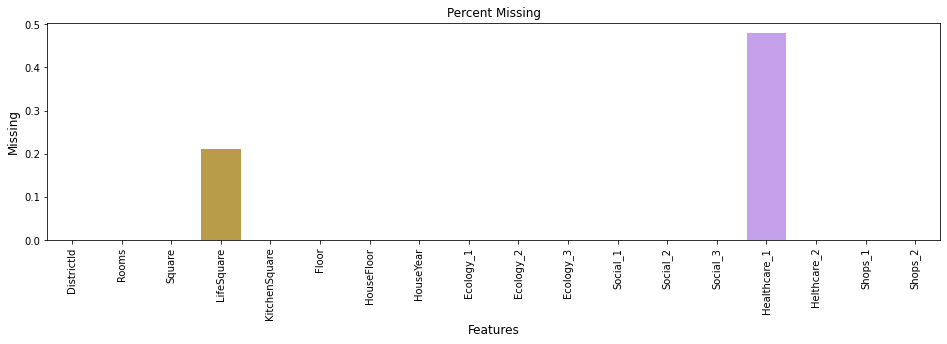

In [17]:
import seaborn as sns

nan_df = (X.isna().sum() / X.shape[0]).reset_index()
nan_df.columns=['feature', 'nan_percent']

plt.figure(figsize=(16,4))
sns.barplot(nan_df['feature'], nan_df['nan_percent'])
plt.title('Percent Missing')
plt.ylabel('Missing', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=90)
plt.show()

# Удалим Healthcare_1
# Заполним LifeSquare

1.2 Feature engineering

In [18]:
X.DistrictId.nunique()

205

In [19]:
dict(X['DistrictId'].value_counts())

{27: 851,
 1: 652,
 23: 565,
 6: 511,
 9: 294,
 62: 247,
 30: 228,
 58: 179,
 53: 174,
 21: 165,
 52: 143,
 8: 142,
 11: 129,
 46: 119,
 61: 118,
 45: 116,
 74: 114,
 34: 111,
 57: 107,
 44: 104,
 99: 97,
 101: 97,
 47: 97,
 13: 97,
 7: 92,
 48: 90,
 29: 89,
 94: 89,
 41: 87,
 3: 82,
 84: 80,
 28: 79,
 2: 78,
 22: 78,
 25: 77,
 85: 76,
 93: 73,
 37: 72,
 90: 72,
 96: 71,
 59: 67,
 75: 66,
 26: 65,
 12: 64,
 88: 64,
 128: 64,
 66: 62,
 67: 61,
 17: 59,
 55: 58,
 39: 57,
 10: 56,
 105: 55,
 31: 55,
 18: 51,
 111: 49,
 119: 49,
 0: 48,
 78: 46,
 91: 44,
 124: 43,
 63: 43,
 129: 43,
 42: 42,
 79: 42,
 109: 41,
 113: 41,
 77: 40,
 54: 37,
 15: 36,
 38: 36,
 24: 35,
 5: 34,
 56: 34,
 32: 34,
 103: 33,
 123: 32,
 19: 31,
 80: 31,
 33: 31,
 83: 31,
 69: 29,
 138: 29,
 130: 29,
 64: 28,
 108: 27,
 86: 27,
 70: 27,
 87: 27,
 120: 26,
 122: 25,
 100: 25,
 121: 25,
 20: 24,
 89: 24,
 107: 23,
 35: 22,
 169: 22,
 98: 21,
 167: 20,
 144: 20,
 145: 19,
 146: 18,
 81: 18,
 134: 18,
 73: 17,
 36: 17,
 

2. Очистка данных

In [20]:
class FeatureImputer:
    """Заполнение пропусков и обработка выбросов"""
    
    def __init__(self):
        self.medians=None
        self.mean = None
        
    # Добавил расчет среднего
    def fit(self, X):
        self.medians = X.median()
        self.mean = X.mean()
    
    def transform(self, X):
        
        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        #Комнаты более 5 и равные 0 заменил на медиану
        X.loc[(X['Rooms'] >= 5) | (X['Rooms'] == 0), 'Rooms'] = self.medians['Rooms']
        
        
        # KitchenSquare
        #Изменил минимальное значение на 5 так-как это разрешенное минимальное значение по закону, меньше кухня не должна быть
        X.loc[X['KitchenSquare'] < 5, 'KitchenSquare'] = 5
        X.loc[X['KitchenSquare'] > 100, 'KitchenSquare'] = self.medians['KitchenSquare']
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        #Изменил подход рассчету этажности дома (медиана этажности домов) 
        # и этажа, превышающего этажность дома (средняя от этажности дома)
        X.loc[(X['HouseFloor'] == 0) & (self.medians['HouseFloor'] > X['Floor']), 'HouseFloor'] = self.medians['HouseFloor']
        X.loc[X['Floor'] > X['HouseFloor'], 'Floor'] = (X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor']/2)
        
        # HouseYear
        # Изменение не несут большого смысла, так как в выборке всего 2 значения, заполненных не корректно
        current_year = now = datetime.datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
           
        # Square
        # X.loc[X['Square'] < X['KitchenSquare'],'Square'] = X['Square'] * 10
        
        # LifeSquare
        # Изменил расчет LifeSquare (по непонятным мне причинам из общей площади вычиталась площадь кухни и еще
        # число 3 взятое за минимальный размер кухни в исходной модели)
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        
        condition = (X['LifeSquare'].isna()) & (~X['Square'].isna()) & (~X['KitchenSquare'].isna())
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare']
        
        #condition = (X['LifeSquare'].isna())
        #X.loc[condition, 'LifeSquare'] = self.medians['LifeSquare']
        
        X.loc[X['LifeSquare'] > X['Square'], 'LifeSquare'] = X['Square'] - X['KitchenSquare']
        
        
        # Ecology_1
        # Попытался почистить Ecology_1, округлиль сильно дробные значения
        X.loc[X['Ecology_1'] == 0.0, 'Ecology_1'] = self.mean['Ecology_1']
        # X['Ecology_1'] = round(X['Ecology_1']*1000)
        
        return X

In [21]:
imputer = FeatureImputer()

imputer.fit(X) # расчет медиан

X = imputer.transform(X)
X_final = imputer.transform(X_final)

3. Feature engineering

In [22]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # DistrictID
        district = X['DistrictId'].value_counts()
        district = district[district > 50]  ## Если вы этого не сделаете, то на Leaderboard-е улетите в самый низ (>100 места, R2 ~ 0.65),
                                            ## Хотя на локальной валидации скор вырастет
        
        self.DistrictId_counts = dict(district)
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # Target encoding
        ## District
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            df['DistrictId_popular'] = df['DistrictId'].copy()
            df.loc[~df['DistrictId_popular'].isin(district.keys().tolist())] = np.nan
            
            self.med_price_by_district = df.groupby(['DistrictId_popular', 'Rooms'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByDistrict',
                                                           'DistrictId_popular': 'DistrictId'})
            
        ## floor, year
        if y is not None:
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
        

        
    def transform(self, X):
        
        # DistrictId
        X['DistrictId_count'] = X['DistrictId'].map(self.DistrictId_counts)  # self.DistrictId_counts = {'id': value}
        
        X['new_district'] = 0
        X.loc[X['DistrictId_count'].isna(), 'new_district'] = 1
        
        X['DistrictId_count'].fillna(5, inplace=True)
        
        # Ecology_1t
        # Фича категорий по экологии (cat)
        X['Ecology_1t'] = 0
        X.loc[X['Ecology_1'] < 100, 'Ecology_1t'] = 1
        X.loc[(X['Ecology_1'] < 200) & (X['Ecology_1'] >= 100), 'Ecology_1t'] = 2
        X.loc[(X['Ecology_1'] < 300) & (X['Ecology_1'] >= 200), 'Ecology_1t'] = 3
        X.loc[(X['Ecology_1'] < 400) & (X['Ecology_1'] >= 300), 'Ecology_1t'] = 4
        X.loc[(X['Ecology_1'] < 500) & (X['Ecology_1'] >= 400), 'Ecology_1t'] = 5
        X.loc[X['Ecology_1'] < 600, 'Ecology_1t'] = 6
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # Ecology_all_in_one
        # Фича общих балов по экологии
        X['Ecology_all'] = (X['Ecology_1t'] + X['Ecology_2'] + X['Ecology_3'])/3
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
        
        return X
    
    @staticmethod
    def floor_to_cat(X):
        
        X['floor_cat'] = np.nan
        
        X.loc[X['Floor'] < 3, 'floor_cat'] = 1  
        X.loc[(X['Floor'] >= 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
        X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
        X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
        X.loc[X['Floor'] > 15, 'floor_cat'] = 5
            
        return X
     
    @staticmethod
    def year_to_cat(X):
        
        X['year_cat'] = np.nan
        
        X.loc[X['HouseYear'] < 1941, 'year_cat'] = 1
        X.loc[(X['HouseYear'] >= 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
        X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
        X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
        X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
        X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6
            
        return X

In [23]:
features = FeatureGenetator()

features.fit(X, y)

X = features.transform(X)
X_final = features.transform(X_final)

In [24]:
X.head(2)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,HouseYear_outlier,LifeSquare_nan,DistrictId_count,new_district,Ecology_1t,Ecology_all,floor_cat,year_cat,MedPriceByDistrict,MedPriceByFloorYear
0,35,2.0,47.981561,29.442751,6.0,7.0,9.0,1969,0.08904,1,...,0,0,5.0,1,6,2.666667,3.0,3.0,NaN,180608.256207
1,41,3.0,65.683640,40.049543,8.0,7.0,9.0,1978,0.00007,1,...,0,0,87.0,0,6,2.666667,3.0,3.0,300009.450063,180608.256207


In [25]:
# подбором изучил влияние фич, их значимость и отклонения модели (малозначимые фичи убрал, результат улучшился)
remain_features = ['DistrictId',       
                   'Rooms',
                   'Square',
                   'KitchenSquare',
                   'LifeSquare',
                   'Floor',
                   'HouseFloor',
                   'HouseYear',
                   'Ecology_1',
                   #'Ecology_2',
                   #'Ecology_3',
                   'Social_1',
                   'Shops_1',
                   #'Shops_2',
                   'MedPriceByDistrict',
                   'MedPriceByFloorYear',
                   'Ecology_all'
                   #'year_cat'
                  ]

X = X[remain_features]
X_final = X_final[remain_features]

4. Модель

In [26]:
# перебором параметров выбран наиболее точный вариант болше на 0.07 от BL R2: 0.735 +- 0.022 (при других выборках были варианты
# и по 0.745, но с большой погрешностью), при выгрузке на kaggel получилось максимум: место 135 ник d zhuntov r2 = 0.74643,
# что ниже BL на ~ 0.001

model = LGBMRegressor(max_depth=7,
                             num_leaves=15,
                             n_estimators=420,
                             random_state=42)

cv_score = cross_val_score(model, X, y, 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))
# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std))

R2: 0.742 +- 0.022


In [27]:
# Обучаю модель на всем трейне
model.fit(X, y)

LGBMRegressor(max_depth=7, n_estimators=420, num_leaves=15, random_state=42)

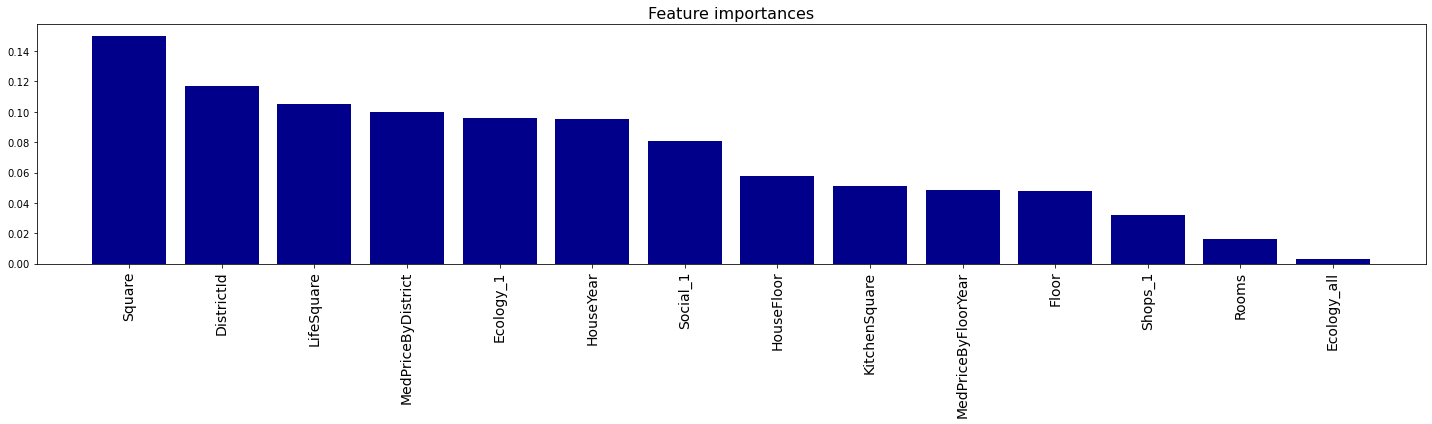

In [28]:
def plot_feature_importances(importances, X):
    
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize = (20, 6))
    plt.title("Feature importances", fontsize=16)
    plt.bar(range(X.shape[1]), importances[indices] / importances.sum(),
           color="darkblue", align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation = 90, fontsize=14)
    plt.xlim([-1, X.shape[1]])

    plt.tight_layout()
    # plt.savefig('fe.jpg')
    plt.show()
    
plot_feature_importances(importances = model.feature_importances_, X=X)

In [29]:
y_pred_final = model.predict(X_final)

preds_final['Price'] = y_pred_final
preds_final.to_csv('predictions.csv', index=False)

preds_final.head()

,Id,Price
0,725,154823.466298
1,15856,233925.558878
2,5480,335717.895105
3,15664,320391.382190
4,14275,143871.982275


In [30]:
preds_final.shape

(5000, 2)

ВЫВОД:
При оценке r2 внутри модели удалость достичь результата, выше BL, но при выгрузках на kaggel результат ниже. Возможно требуется рассмотреть варианты, когда r2 не высокий при подборе фич (но на сайте значение будет выше, то есть не ориентироваться на внутреннее значение). Основными фичами являются: Square, DistrictID, LifeSquer, Ecology_1, HousYaer, Social_1 следовательно их дальнейшая обработка (очистка) и генерация новых фичей должны повысить результат.